<a href="https://colab.research.google.com/github/kky107102/ML_TEAM8/blob/main/cifake_resnet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bbbbbbaan","key":"04d2d06d8a3a905749b23ad0b5af2cdc"}'}

In [ ]:
!mkdir -p~/.kaggle
!cp kaggle.json ~/kaggle/
!chmod 600~/.kaggle/kaggle.json

mkdir: invalid option -- '~'
Try 'mkdir --help' for more information.
cp: cannot create regular file '/root/kaggle/': Not a directory
chmod: missing operand after ‘600~/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


In [ ]:
!kaggle datasets download -d birdy654/cifake-real-and-ai-generated-synthetic-images

Dataset URL: https://www.kaggle.com/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images
License(s): other
 98% 102M/105M [00:05<00:00, 22.5MB/s] 
100% 105M/105M [00:05<00:00, 19.2MB/s]


In [ ]:
!ls

cifake-real-and-ai-generated-synthetic-images.zip  kaggle.json	sample_data


In [ ]:
!unzip cifake-real-and-ai-generated-synthetic-images.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/REAL/4500 (10).jpg  
  inflating: train/REAL/4500 (2).jpg  
  inflating: train/REAL/4500 (3).jpg  
  inflating: train/REAL/4500 (4).jpg  
  inflating: train/REAL/4500 (5).jpg  
  inflating: train/REAL/4500 (6).jpg  
  inflating: train/REAL/4500 (7).jpg  
  inflating: train/REAL/4500 (8).jpg  
  inflating: train/REAL/4500 (9).jpg  
  inflating: train/REAL/4500.jpg     
  inflating: train/REAL/4501 (10).jpg  
  inflating: train/REAL/4501 (2).jpg  
  inflating: train/REAL/4501 (3).jpg  
  inflating: train/REAL/4501 (4).jpg  
  inflating: train/REAL/4501 (5).jpg  
  inflating: train/REAL/4501 (6).jpg  
  inflating: train/REAL/4501 (7).jpg  
  inflating: train/REAL/4501 (8).jpg  
  inflating: train/REAL/4501 (9).jpg  
  inflating: train/REAL/4501.jpg     
  inflating: train/REAL/4502 (10).jpg  
  inflating: train/REAL/4502 (2).jpg  
  inflating: train/REAL/4502 (3).jpg  
  inflating: train/REAL/4502 (4).jpg  
  inflating: train/REAL/450

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, ResNet50, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Dropout, Flatten, Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.saving import load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import os
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import average_precision_score
import numpy as np
import pandas as pd
import random
import shutil

In [ ]:
dataset_dir = "/content/"

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True,
    validation_split=0.1
)

train_img = train_datagen.flow_from_directory(dataset_dir + 'train' ,class_mode='binary'
, batch_size=1024 , subset="training",target_size=(299, 299) ,shuffle=True)
valid_img = train_datagen.flow_from_directory(dataset_dir + 'train' ,class_mode='binary'
, batch_size=1024 ,subset="validation", target_size=(299, 299),shuffle=True)

print(train_img.class_indices)
print(valid_img.class_indices)

Found 90000 images belonging to 2 classes.
Found 10000 images belonging to 2 classes.
{'FAKE': 0, 'REAL': 1}
{'FAKE': 0, 'REAL': 1}


In [ ]:
from keras.applications import ResNet50
from keras.layers import Input

# 입력 크기 지정
input_shape = (299, 299, 3)

# ResNet50 모델 정의 및 가중치 로드
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# 모든 레이어를 동결
for layer in base_model.layers:
    layer.trainable = False

#사전 훈련된 가중치 로드

94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:
x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

In [ ]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = .001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [ ]:
history = model.fit(train_img,
                    validation_data=valid_img,
                    epochs=3,
                    #callbacks = [callback]
)

Epoch 1/3
88/88 [==============================] - 7255s 82s/step - loss: 4.5913 - accuracy: 0.6069 - precision: 0.6070 - recall: 0.6063 - val_loss: 1.7287 - val_accuracy: 0.5251 - val_precision: 0.5129 - val_recall: 0.9986
Epoch 2/3
88/88 [==============================] - 7006s 80s/step - loss: 0.7312 - accuracy: 0.6771 - precision: 0.6727 - recall: 0.6901 - val_loss: 0.5032 - val_accuracy: 0.7591 - val_precision: 0.8707 - val_recall: 0.6086
Epoch 3/3
88/88 [==============================] - 6904s 78s/step - loss: 0.7284 - accuracy: 0.7021 - precision: 0.6959 - recall: 0.7178 - val_loss: 0.6276 - val_accuracy: 0.6636 - val_precision: 0.9384 - val_recall: 0.3502


In [ ]:
model.save("/content/modelwithAdam.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


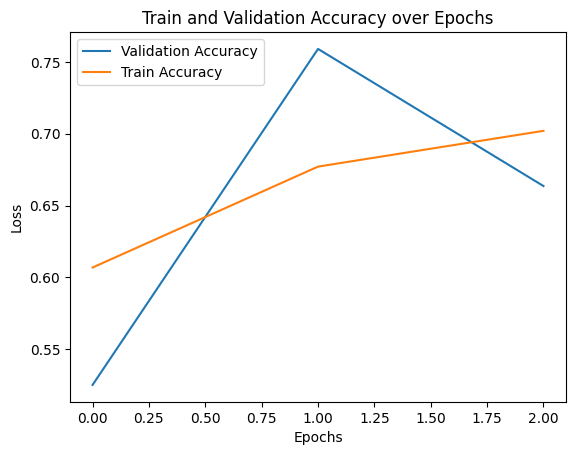

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(val_accuracy, label='Validation Accuracy')
plt.plot(accuracy, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Accuracy over Epochs')
plt.savefig('modelwithAdaDeltaAccuracy.png')
plt.legend()
plt.show()

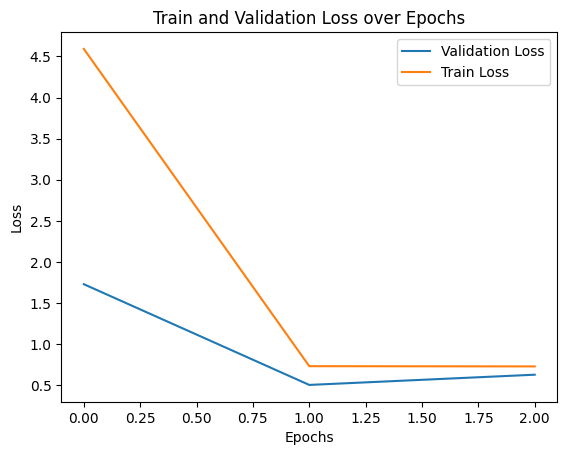

In [ ]:
val_loss = history.history['val_loss']
train_loss = history.history['loss']
plt.plot(val_loss, label='Validation Loss')
plt.plot(train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss over Epochs')
plt.savefig('modelwithAdaDeltaloss.png')
plt.legend()
plt.show()

In [ ]:
#이미지 전처리
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(dataset_dir + 'test', target_size=(299,299), batch_size=128, class_mode='binary', shuffle=False)


Found 20000 images belonging to 2 classes.


In [ ]:
#성능평가
scores = model.evaluate(test_generator)
print('Baseline error: %.2f' % (1-scores[1]))
print("Accuracy = %.2f" %scores[1])

157/157 [==============================] - 1416s 9s/step - loss: 0.6361 - accuracy: 0.6579 - precision: 0.9347 - recall: 0.3394
Baseline error: 0.34
Accuracy = 0.66


In [ ]:
predict_prob = model.predict(test_generator)
labels = [0 if pred < 0.5 else 1 for pred in predict_prob]

accuracy = np.sum(np.array(test_generator.labels) == np.array(labels)) / len(labels)

print("\nAccuracy:", accuracy)

cm = confusion_matrix(test_generator.labels, labels)
print("\nConfusion Matrix:")
print(cm)

class_names = test_generator.class_indices.keys()
classification_rep = classification_report(test_generator.labels, labels, target_names=class_names)
print("\nClassification Report:")
print(classification_rep)

mAP = average_precision_score(test_generator.labels,  predict_prob)
print("\nMean Average Precision (mAP):", mAP)

157/157 [==============================] - 1467s 9s/step

Accuracy: 0.65785

Confusion Matrix:
[[9763  237]
 [6606 3394]]

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.60      0.98      0.74     10000
        REAL       0.93      0.34      0.50     10000

    accuracy                           0.66     20000
   macro avg       0.77      0.66      0.62     20000
weighted avg       0.77      0.66      0.62     20000


Mean Average Precision (mAP): 0.8785018862382865


In [ ]:
import seaborn as sns


cm = confusion_matrix(test_generator.labels, labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig('ModelwithAdamConfusionMatrix.png')
plt.show()

NameError: name 'confusion_matrix' is not defined